# Analysis of SARS-Cov-2 intrasample variation

You can access your data via the dataset number. For example, ``handle = open(get(42), 'r')``.
To save data, write your data to a file, and then call ``put('filename.txt')``. The dataset will then be available in your galaxy history.
Notebooks can be saved to Galaxy by clicking the large green button at the top right of the IPython interface.<br>
More help and informations can be found on the project [website](https://github.com/bgruening/galaxy-ipython).

In [1]:
# Set display to the full length

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 752kB/s eta 0:00:01
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1


In [3]:
!pip install --upgrade seaborn

     |████████████████████████████████| 216 kB 3.4 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1


In [4]:
# install pandasql
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=28405 sha256=92a9f6e8b3a4f8ad366a0be0185e11eefcb4938ac8f0f78a7088c177e675c428
  Stored in directory: /home/jovyan/.cache/pip/wheels/33/dc/52/fcd9f8b4528e668922f2b776e423db0a07bdd973ea02ffd2ef
Successfully built pandasql


In [5]:
import pandas as pd
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
%matplotlib inline

This notebook imports two datasets from Galaxy history:

 - a table of variants 
 - a GenBank file for NC_045512

In [6]:
# Import two datasets
# The number inside `get()` function corresponds to history ID

var_file = 6     # Number of history item with variant list
gb_file = 4      # Number of histoiry item containing genbank annoration for NC_045512

var_path = get(var_file)
gb_path = get(gb_file)

In [7]:
# Clean artifacts of SNPeff from file headers

!cat {var_path} | sed s/EFF\\\[\\\*\\\]\.//g > var.tab

In [8]:
# Create dataframes

var  = pd.read_csv('var.tab', sep='\t')

In [9]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON
0,SRR10903401,NC_045512,1409,C,T,126,0.039683,1,"67,54,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat
1,SRR10903401,NC_045512,1821,G,A,93,0.096774,0,"48,36,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt
2,SRR10903401,NC_045512,1895,G,A,106,0.037736,0,"51,51,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata
3,SRR10903401,NC_045512,2407,G,T,123,0.024390,0,"57,63,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG


In [10]:
# Add fiels describing viant type and set it to "I" (indels) for those rows that reference or alternative are gaps (-)
# or are of unequial length

var.loc[ ( var['REF'] == '-' ) | ( var['ALT'] == '-' ) ,'type'] = 'I'
var.loc[ ( var['ALT'].str.len() != var['REF'].str.len() ), 'type' ] = 'I'

In [11]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR10903401,NC_045512,1409,C,T,126,0.039683,1,"67,54,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat,NaN
1,SRR10903401,NC_045512,1821,G,A,93,0.096774,0,"48,36,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt,NaN
2,SRR10903401,NC_045512,1895,G,A,106,0.037736,0,"51,51,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata,NaN
3,SRR10903401,NC_045512,2407,G,T,123,0.024390,0,"57,63,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT,NaN
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG,NaN


In [12]:
# Set type field for SNPs
var.loc[ ( var['REF'].str.len() == 1 ) & ( var['ALT'].str.len() == 1 ) & (var['type'].isnull()), 'type'] = 'S'

In [13]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR10903401,NC_045512,1409,C,T,126,0.039683,1,"67,54,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat,S
1,SRR10903401,NC_045512,1821,G,A,93,0.096774,0,"48,36,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt,S
2,SRR10903401,NC_045512,1895,G,A,106,0.037736,0,"51,51,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata,S
3,SRR10903401,NC_045512,2407,G,T,123,0.024390,0,"57,63,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT,S
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG,S


In [14]:
# Set type field for MNPs 
var.loc[ ( ( var['REF'].str.len() > 1 ) & ( var['ALT'].str.len() == var['REF'].str.len() ) ) , 'type'  ] = 'M'

In [15]:
var.head()

,Sample,CHROM,POS,REF,ALT,DP,AF,SB,DP4,IMPACT,FUNCLASS,EFFECT,GENE,CODON,type
0,SRR10903401,NC_045512,1409,C,T,126,0.039683,1,"67,54,2,3",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Cat/Tat,S
1,SRR10903401,NC_045512,1821,G,A,93,0.096774,0,"48,36,5,4",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,gGt/gAt,S
2,SRR10903401,NC_045512,1895,G,A,106,0.037736,0,"51,51,2,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,Gta/Ata,S
3,SRR10903401,NC_045512,2407,G,T,123,0.024390,0,"57,63,1,2",MODERATE,MISSENSE,NON_SYNONYMOUS_CODING,orf1ab,aaG/aaT,S
4,SRR10903401,NC_045512,3379,A,G,121,0.024793,0,"56,62,1,2",LOW,SILENT,SYNONYMOUS_CODING,orf1ab,gtA/gtG,S


In [16]:
# Select counts by Sample and by type

pysqldf('select Sample, type, count(*) from var group by Sample, type')

,Sample,type,count(*)
0,SRR10903401,S,70
1,SRR10903402,S,215
2,SRR10971381,S,96
3,SRR11059940,S,3
4,SRR11059942,S,924
5,SRR11059943,S,130
6,SRR11059944,S,1055
7,SRR11059945,S,497
8,SRR11059946,S,10788
9,SRR11059947,S,20545


In [17]:
# Select counts by Sample and by type for SNPs wil allele frequency above 5%

pysqldf('select Sample, type, count(*) from var where AF >= 0.05 group by Sample, type')

,Sample,type,count(*)
0,SRR10903401,S,9
1,SRR10903402,S,6
2,SRR10971381,S,14
3,SRR11059940,S,3
4,SRR11059942,S,103
5,SRR11059943,S,34
6,SRR11059944,S,7
7,SRR11059945,S,30
8,SRR11059946,S,40
9,SRR11059947,S,7


In [18]:
pysqldf('select Sample, EFFECT, count(*) as N from var group by Sample, EFFECT').pivot(index='Sample',columns='EFFECT',values='N').fillna(0)

EFFECT,.,NON_SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING+SPLICE_SITE_REGION,NON_SYNONYMOUS_START,SPLICE_SITE_REGION+SYNONYMOUS_CODING,SPLICE_SITE_REGION+SYNONYMOUS_STOP,START_LOST,STOP_GAINED,STOP_LOST,STOP_LOST+SPLICE_SITE_REGION,SYNONYMOUS_CODING,SYNONYMOUS_STOP
Sample,,,,,,,,,,,,
SRR10903401,0.0,43.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,23.0,0.0
SRR10903402,4.0,138.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,69.0,0.0
SRR10971381,3.0,46.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,43.0,0.0
SRR11059940,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
SRR11059942,10.0,570.0,0.0,0.0,0.0,1.0,1.0,11.0,0.0,1.0,330.0,0.0
SRR11059943,0.0,84.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,42.0,0.0
SRR11059944,11.0,660.0,1.0,0.0,0.0,1.0,1.0,17.0,0.0,1.0,363.0,0.0
SRR11059945,3.0,298.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,192.0,0.0
SRR11059946,108.0,6504.0,0.0,1.0,0.0,8.0,18.0,104.0,0.0,6.0,4039.0,0.0


In [19]:
pysqldf('select Sample, EFFECT, count(*) as N from var where AF >= 0.05 group by Sample, EFFECT').pivot(index='Sample',columns='EFFECT',values='N').fillna(0)

EFFECT,.,NON_SYNONYMOUS_CODING,START_LOST,STOP_GAINED,SYNONYMOUS_CODING
Sample,,,,,
SRR10903401,0.0,4.0,0.0,1.0,4.0
SRR10903402,1.0,4.0,0.0,0.0,1.0
SRR10971381,0.0,6.0,1.0,0.0,7.0
SRR11059940,0.0,2.0,0.0,0.0,1.0
SRR11059942,0.0,77.0,0.0,2.0,24.0
SRR11059943,0.0,24.0,0.0,1.0,9.0
SRR11059944,0.0,5.0,0.0,0.0,2.0
SRR11059945,0.0,22.0,0.0,0.0,8.0
SRR11059946,3.0,24.0,0.0,3.0,10.0


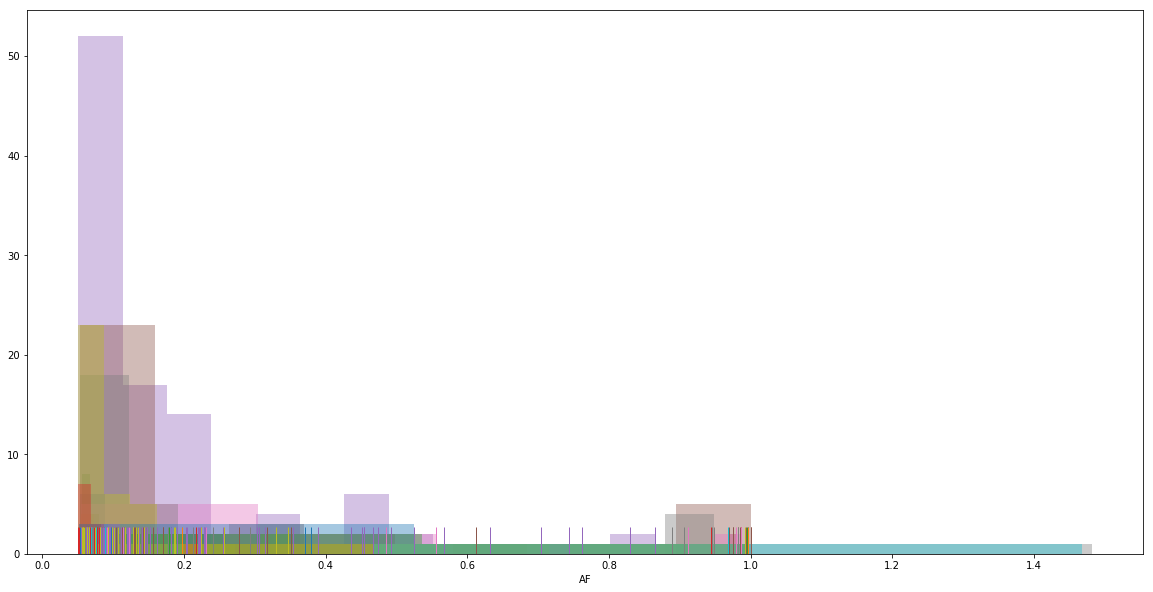

In [20]:
# Plot histogram of allele frequencies for three sample
# Restricted to variants with minor allele frequency above 5%

plt.figure(figsize=(20,10))
for sample in var['Sample'].unique():
    sns.distplot(var['AF'][(var['AF']>=0.05) & (var['Sample']==sample)],kde=False,rug=True)

In [21]:
# Define categorical columns

for col in ['IMPACT','FUNCLASS','EFFECT']:
    var[col] = var[col].astype('category')

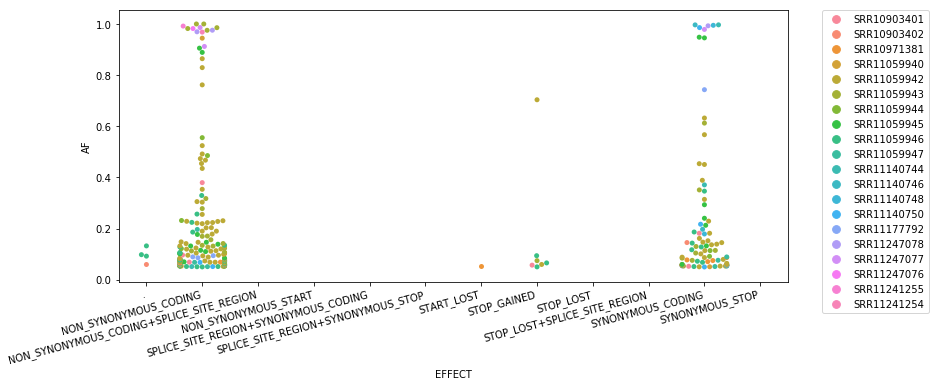

In [22]:
# Plot Allele frequences by samples and functional categories

plt.figure(figsize=(12,5))
g = sns.swarmplot(x='EFFECT',y='AF',data=var[var['AF']>=0.05], hue='Sample')
g.set_xticklabels(g.get_xticklabels(), rotation=15, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
# Read GenBank file with annotations for NC_045512
from Bio import SeqIO
record = SeqIO.read(gb_path,'genbank')

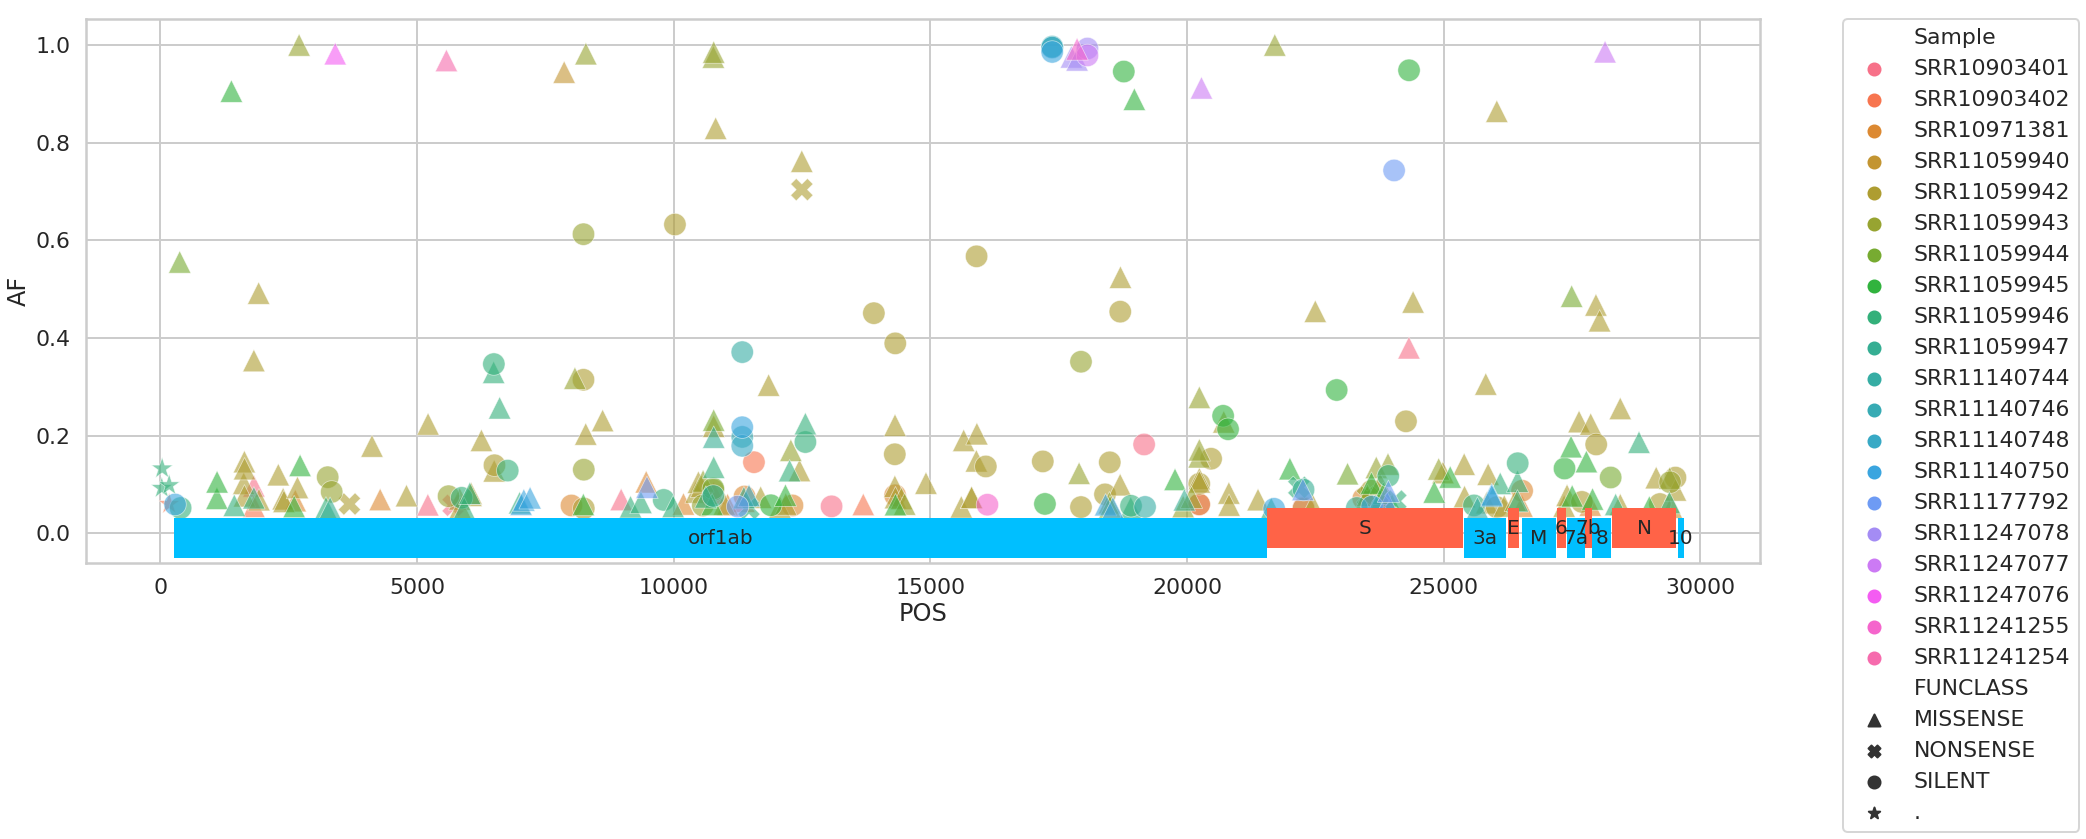

In [24]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set_context("poster")
sns.set_style("whitegrid")
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o"}
sns.scatterplot(x='POS',y='AF',data=var[var['AF']>=0.05],hue='Sample',style='FUNCLASS',legend='brief',alpha=0.6,s=500,markers=markers)
i = 0
for feature in record.features:
    if feature.type == 'gene':
        i += 1
        gene_name = feature.qualifiers['gene'][0]
        if gene_name.startswith('ORF'):
            gene_name=gene_name[3:]
        if i % 2 == 0:
            color ='tomato'
            y = 0.01
        else:
            color ='deepskyblue'
            y = -0.01
        plt.hlines(y,feature.location._start.position, feature.location._end.position, linewidth=40,color=color)
        plt.text(feature.location._start.position+(feature.location._end.position-feature.location._start.position)//2, y, gene_name,horizontalalignment='center',verticalalignment='center',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [25]:
# List varinats by Sample and by position highlighting allel frequencies

var[var['AF']>0.05].sort_values(by=['AF','POS'],ascending=False).style.bar(subset=['AF'],color='#d65f5f')